# Udacity Deep Reinforcement Learning Nanodegree Navigation Project

# Method

The agent uses the following tools, notions and techniques to solve the environment:
- **Deep Q Learning**: the Q-value function, which maps state values to action values and lets the agent pick the *best* action (the one most likely to optimize the total reward), is approximated by a neural network
- **Fixed Q-Targets with soft updates**: the algorithm uses two separate *local* and *target* networks with identical architectures, the local network is used as policy and the target network is updated with soft updates to smooth learning
- **Epsilon-greedy action selection with epsilon decay**: the agent picks a random action with a probability of $\epsilon$ which decays over time, to prevent the agent's actions from locking it into too specific situations
- **Experience Replay**: instead of learning at every step from the experience it just got, the agent stores every experience (state, action, next state, reward and done flag) in a fixed-size memory and, every few steps, samples a batch of experiences to learn from
- **Prioritized Experience Replay**: uniform sampling of experiences draws more on frequent experiences than infrequent ones... it is especially harmful in our current context, since the experience of collecting a banana (good or bad) is much less frequent than the less meaningful experience of moving and nothing happening (i.e. `reward == 0`). Experiences are thus stored with a priority value (the TD error seems to be most frequently used for that purpose) and sampling is done in a prioritized way, to ensure that meaningful experiences are more likely to surface during learning.

## Neural network architecture

The neural networks share the following architecture:
- An input layer of `37` nodes corresponding to the 37 values defining a state of the environment
- A first fully connected hidden layer with `64` nodes and a ReLU activation
- A second fully connected hidden layer with `64` nodes and a ReLU activation
- An output layer of `4` nodes corresponding to the 4 possible actions

<img src="nn-architecture.png">

Note: apart from the input and output layers that are obviously tied to the environment, the architecture is the same as the one used in Udacity's DQN algorithm.

## Hyper-parameters

- Memory
  - Buffer size: $1e^5$ as in Udacity's DQN algorithm
  - Minimum priority: $1e^{-5}$ (inverse of the buffer size) to ensure all experiences have at least a tiny chance to be sampled
  - Priority factor: $90\%$ as a first try value which seemed to work fine
- Soft updates
  - Tau $\tau$: $1e^{-3}$ as in Udacity's DQN algorithm
- Training
  - Batch size: $64$ as in Udacity's DQN algorithm
  - Gamma $\gamma$ discount factor: $0.99$ as in Udacity's DQN algorithm
  - Learning rate: $1e^{-4}$ which is 5 times smaller than the value used in Udacity's DQN algorithm, because smaller values seemed to help the algorithm learn faster
  - Update interval: $4$ as in Udacity's DQN algorithm

# Implementation

## Initial setup

Please follow the instructions of `README.md` (found in the same root folder as the present notebook) to install the required packages and download the game environment.

## Imports

The following packages are required for the notebook to work.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from collections import deque, namedtuple, OrderedDict
from IPython.display import Audio
from torch.nn.functional import mse_loss
from tqdm.notebook import trange
from unityagents import UnityEnvironment

import matplotlib.pyplot as plt
%matplotlib inline

## Deep Q Network

In [2]:
class DQN(nn.Module):
    """Actor (Policy) Model"""

    def __init__(self, layer_sizes):
        """Build a neural network with a series of linear hidden layers and ReLU activation
        :param list layer_sizes: sizes of all layers, from input to output,
                                 e.g. [37, 64, 64, 4] for two hidden layers
        """
        
        super(DQN, self).__init__()

        # Define the layers
        layers = OrderedDict()
        for i in range(len(layer_sizes) - 1):
            layers['fc{}'.format(i)] = nn.Linear(layer_sizes[i], layer_sizes[i+1])
            if i + 2 < len(layer_sizes): # Last layer does not have a ReLU
                layers['relu{}'.format(i)] = nn.ReLU()

        # Define the model
        self.model = nn.Sequential(layers)

    def forward(self, state):
        """Forward pass through the DQN to compute action values based on provided state
        :param state: current state of the environment
        :return: action values as per current policy
        """
        
        return self.model(state)

## Prioritized Replay Buffer

In [3]:
BUFFER_SIZE = 100000   # maximum number of prior experiences kept in memory
MIN_PRIORITY = 1e-5    # minimum priority to ensure no experience is entirely unusable for learning
PRIORITY_FACTOR = 0.9  # 0 = uniform sampling, 1 = fully prioritized sampling

In [4]:
class PrioritizedReplayBuffer:
    """Fixed-size buffer to store experience tuples and retrieve them based on priorities"""

    def __init__(self, batch_size, device):
        """
        :param int batch_size: size of each training batch
        :param str device: device to use for training
        """
        
        self.device = device
        self.batch_size = batch_size
        
        # Prepare storage of experiences
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

        # Initialize memory to store the experiences
        self.memory = deque(maxlen=BUFFER_SIZE)
        
        # Initialize buffer to store the priority values associated with the experiences
        self.priorities = deque(maxlen=BUFFER_SIZE)

    def add(self, state, action, reward, next_state, done, priority):
        """Commit an experience to memory (and possibly eject the oldest experience, if buffer size is reached)
        :param state: state of the environment before the agent acted
        :param action: action the agent chose
        :param reward: reward the environment bestowed on the agent
        :param next_state: state of the environment after the agent acted
        :param done: False if the episode is still ongoing
        :param priority: importance of the experience (generally TD error)
        """
        
        # Prepare named tuple
        e = self.experience(state, action, reward, next_state, done)

        # Commit experience to memory
        self.memory.append(e)
        
        # Save priority of experience (or minimum if the priority given is too low)
        self.priorities.append(max(priority, MIN_PRIORITY))

    def sample(self):
        """Randomly samples a batch of experiences based on their priorities"""
        
        # Prepare sampling probabilities
        adjusted_priorities = np.array(self.priorities) ** PRIORITY_FACTOR
        sampling_probabilities = list(adjusted_priorities / np.sum(adjusted_priorities))

        # Sample experiences
        indices = np.random.choice(len(self.memory), size=self.batch_size, p=sampling_probabilities)
        experiences = [self.memory[idx] for idx in indices]

        # Prepare data
        states = torch.from_numpy(np.vstack([e.state
                                             for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action
                                              for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward
                                             for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e.next_state
                                                  for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None])
                                 .astype(np.uint8)).float().to(self.device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        """Return the current size of internal memory"""
        
        return len(self.memory)

## Soft updates

In [5]:
TAU = 1e-3  # Parameter of the soft update

In [6]:
def soft_update(local_model, target_model):
    """Soft update model parameters: θ_target = τ*θ_local + (1 - τ)*θ_target
    :param local_model: PyTorch model the weights are copied from
    :param target_model: PyTorch model the weights are copied to
    """
    
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
        target_param.data.copy_(TAU * local_param.data + (1.0 - TAU) * target_param.data)

## Agent

In [7]:
BATCH_SIZE = 64           # Size of the training batches
GAMMA = 0.99              # Reward discount factor
LAYERS = [37, 64, 64, 4]  # Dimensions of the DQN layers including input/state and output/action
LR = 1e-4                 # Learning rate
UPDATE_EVERY = 4          # Interval between updates of the target Q network

In [8]:
class Agent:
    """Interacts with and learns from the environment"""

    def __init__(self, device):
        """Initialize everything the agent needs to learn
        :param str device: device to use for training
        """
        
        self.device = device

        # Save size of output layer
        self.action_size = LAYERS[-1]

        # Define the double Q networks
        self.local_dqn = DQN(LAYERS).to(device)
        self.target_dqn = DQN(LAYERS).to(device)
        self.optimizer = optim.Adam(self.local_dqn.parameters(), lr=LR)

        # Setup a prioritized replay buffer
        self.memory = PrioritizedReplayBuffer(BATCH_SIZE, device)

        # Initialize time step to update the target network only every UPDATE_EVERY steps
        self.t_step = 0

    def eval(self, state):
        """Returns complete output of local network for a given state (i.e. all action values)
        :param state: state that will be fed to the local network
        :return: complete output of the network
        """
        
        # Prepare input
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)

        # Get action values (with training mode OFF)
        self.local_dqn.eval()
        with torch.no_grad():
            action_values = self.local_dqn(state)
        self.local_dqn.train()

        return action_values.cpu().data.numpy()[0]

    def learn(self, experiences):
        """Learn from a batch of experience tuples
        :param Tuple[torch.Tensor] experiences: batch of (s, a, r, s', done) tuples
        """
        
        # Unpack batch
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values from target network
        q_targets_next = self.target_dqn(next_states).detach().max(1)[0].unsqueeze(1)
        
        # Compute Q targets
        q_targets = rewards + (GAMMA * q_targets_next * (1 - dones))

        # Get expected Q values from local network
        q_expected = self.local_dqn(states).gather(1, actions)

        # Compute loss
        loss = mse_loss(q_expected, q_targets)

        # Back-prop
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Soft update of the target network
        soft_update(self.local_dqn, self.target_dqn)

    def step(self, state, action, reward, next_state, done):
        """Save experience in memory and learn every UPDATE_EVERY time steps
        :param state: state of the environment before the agent acted
        :param action: action the agent chose
        :param reward: reward the environment bestowed on the agent
        :param next_state: state of the environment after the agent acted
        :param done: False if the episode is still ongoing
        """
        
        # Compute TD error to use as priority
        td_error = abs(reward + GAMMA * max(self.eval(next_state)) - self.eval(state)[action])

        # Commit experience to memory
        self.memory.add(state, action, reward, next_state, done, td_error)

        # Update time step
        self.t_step = (self.t_step + 1) % UPDATE_EVERY

        # Learn every UPDATE_EVERY time steps if enough samples are available
        if self.t_step == 0 and len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences)

    def act(self, state, eps=0.0):
        """Returns an action for a given state as per current policy
        :param state: state of the environment
        :param eps: epsilon for epsilon-greedy action selection
        :return: action chosen by the agent
        """
        
        # Prepare input
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)

        # Get action values from local network with training mode OFF
        self.local_dqn.eval()
        with torch.no_grad():
            action_values = self.local_dqn(state)
        self.local_dqn.train()

        # Epsilon-greedy action selection
        if np.random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy()).astype(np.int32)
            # Note: without type conversion, argmax sometimes outputs a 64-bit integer that wrecks the UnityEnvironment
        else:
            return np.random.choice(np.arange(self.action_size))

## Unity Environment

Modify the next line so that the `file_name` parameter matches the location of the Unity environment you downloaded.

In [9]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


An empty Unity window should have opened. If you switch to it during training or testing, you will be able to watch the agent in action.

**Note**: if the environment is set to training mode, the action will be so fast, it might be uncomfortable to watch.

Once the environment is launched, we need to connect to it via a *brain name*. In some Unity environments, there are more than one brain/agent to control, but in the present case, there is only one.

In [10]:
# Connect to the default (and only) brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## Training

In [11]:
SCORE_WINDOW_SIZE = 100
TARGET_AVG_SCORE = 13

In [12]:
def train(max_episodes=2000, max_t=300, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Trains the agent until it reaches the defined goal or the maximum number of episodes
    :param int max_episodes: limit number of episodes to try to reach the goal
    :param int max_t: upper limit of time steps (in case the environment itself never stops the episode)
    :param float eps_start: initial value of epsilon for epsilon-greedy action selection
    :param float eps_end: final value of epsilon for epsilon-greedy action selection
    :param float eps_decay: decay value to decrease epsilon over time
    :return: scores of all episodes
    """
    
    # Use CUDA if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Initializations
    agent = Agent(device)
    eps = eps_start
    _scores = []
    score_window = deque(maxlen=SCORE_WINDOW_SIZE)
    
    # Episode loop
    episode_iterator = trange(1, max_episodes + 1, desc="Training")
    for episode in episode_iterator:
        # Reset score
        score = 0

        # Reset the environment in training mode
        env_info = env.reset(train_mode=True)[brain_name]

        # Fetch first state of the environment
        state = env_info.vector_observations[0]

        # Time steps loop
        for t in range(max_t):
            # Let the agent pick an action
            action = agent.act(state, eps)

            # Apply the chosen action on the environment
            env_info = env.step(action)[brain_name]

            # Extract the results of the action
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]

            # Let the agent memorize and learn from the experience 
            agent.step(state, action, reward, next_state, done)

            # Update the score and state
            score += reward
            state = next_state

            # Stop if the episode is finished
            if done:
                break

        # Save the score
        _scores.append(score)
        score_window.append(score)

        # Decrease epsilon
        eps = max(eps_end, eps_decay * eps)

        # Compute average score
        avg_score = np.mean(score_window)

        # Log
        episode_iterator.set_postfix(score=score, average_score=avg_score, epsilon=eps)

        # Save the model weights for comparison of behavior
        if episode % SCORE_WINDOW_SIZE == 0:
            torch.save(agent.local_dqn.state_dict(), 'checkpoint-{}.pth'.format(episode))
        
        # Stop if the goal is reached
        if avg_score >= TARGET_AVG_SCORE:
            torch.save(agent.local_dqn.state_dict(), 'checkpoint-solved-{}.pth'.format(episode))
            episode_iterator.close()
            break

    return _scores

In [13]:
scores = train()
Audio('notification.wav', autoplay=True) # This line will play a sound when training stops

The average score of episodes `1027` to `1127` is above `13`. Our agent has managed to reach the goal in fewer than 1800 episodes.

## Plot score evolution

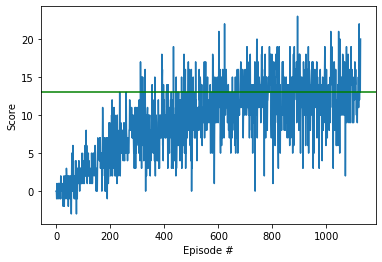

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.axhline(y=13.0, color='g', linestyle='-')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Clearly the score varies a lot from an episode to the next. It can be explained by the random nature of the environment itself: in some episodes, the agent starts surrounded by blue bananas and has a hard time getting all the way to the yellow ones in time to get a good score. Conversely, if most yellow bananas spawn near the agent's starting point, it will rack up a huge score that will be well above its average.

## Loading and using a trained model

In [19]:
def evaluate(model_file_name):
    """Loads previously saved weights into an agent and lets it play one episode with training mode off
    :param str model_file_name: path to the file containing the saved weights to load
    """
    
    # Use CUDA if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # Initialize a new agent
    agent = Agent(device)

    # Load weights
    agent.local_dqn.load_state_dict(torch.load(model_file_name))

    # Reset environment
    env_info = env.reset(train_mode=False)[brain_name]
    
    # Initialize variables
    score = 0
    done = False
    state = env_info.vector_observations[0]
    
    # During the whole episode
    while not done:
        # Pick an action
        action = agent.act(state)
        
        # Perform the action on the environment
        env_info = env.step(action)[brain_name]
        
        # Extract updated info from the environment
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        
        # Update the score and state
        score += reward
        state = next_state
    
    print("Scored {}".format(score))
    
    return score

In [21]:
evaluate("checkpoint-solved-1127.pth")

Scored 14.0


14.0

Here is what the agent looks like in action:

<img src="solved-1127.gif">

## Closing the Unity Environment

In [26]:
env.close()

# Conclusion

Udacity's DQN algorithm that solved OpenAI Gym's LunarLander worked for this Unity environment almost as-is. One minor adjustment (decreasing the learning rate sped up the agent's learning) and one major improvement (prioritized experience replay) were enough to meet the project's goals.

Looking at the agent's behavior, it clearly seems to know that yellow bananas are desirable and blue bananas must be avoided. It sometimes jerks sideways and it is hard to tell whether it is a meaningless motion or if the agent is trying to better assess the positions of bananas in the environment to plan its next moves...

Many potential improvements could be considered besides more fine-tuning of the hyper-parameters, including using Double DQNs, Dueling DQNs or switching to the Rainbow algorithm which incorporates all those improvements.

It would be very helpful to be able to set the random seed of the environment itself. Without that feature, setting the random seeds in our algorithm will not ensure reproducible results. The randomness of the environment makes comparing different sets of hyperparameters a little bit harder.

# References

1. Mnih, Volodymyr, et al. "Human-level control through deep reinforcement learning" Nature518.7540 (2015): 529 [PDF](http://www.davidqiu.com:8888/research/nature14236.pdf)
2. Schaul, Tom, et al. "Prioritized Experience Replay" arXiv:1511.05952 cs.LG [PDF](https://arxiv.org/pdf/1511.05952)

# Credits

- The algorithm this one is based on is the [Deep Q-Network algorithm by Udacity](https://github.com/udacity/deep-reinforcement-learning/tree/master/dqn)
- The neural network architecture diagram was generated with [NN SVG](http://alexlenail.me/NN-SVG/index.html)
then edited with [Inkscape](https://inkscape.org/)
- The GIF recordings were made with [ScreenToGif](https://www.screentogif.com/)
- The notification sound was found on [WavSource.com](http://www.wavsource.com/video_games/pac-man.htm)